Capstone project jupyter notebook

In [1]:
import os

import matplotlib.pyplot as plt
import qlib
import torch
import time
import numpy as np
import pandas as pd
from torch import nn
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import ZScoreNorm, Fillna
from qlib.utils import init_instance_by_config
from torch.utils.data import DataLoader, Dataset
from audtorch.metrics.functional import pearsonr
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import cvxpy as cp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In this project, we use a Macbook pro with pytroch supported package

In [4]:
device = torch.device("mps")
device

device(type='mps')

Config the dataset and data preprocessing using qlib

In [4]:
market = "csi100"
benchmark = "SH000903"
data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-06-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
    "learn_processors": [
        {
            "class" : "DropCol",
            "kwargs":{"col_list": ["VWAP0","KUP","KUP2","HIGH0","IMIN5"]}
        },
        {
            "class" : "DropnaProcessor",
            "kwargs":{"fields_group": "feature"}
        },
        {
            "class" : "DropnaProcessor",
            "kwargs":{"fields_group": "label"}
        },
        {
            "class": "CSZScoreNorm",
            "kwargs": {"fields_group": "label"}
        },
        {
            "class": "CSZScoreNorm",
            "kwargs": {"fields_group": "feature"}
        }
    ],
    "infer_processors": [
        {
            "class" : "DropCol",
            "kwargs":{"col_list": ["VWAP0","KUP","KUP2","HIGH0","IMIN5"]}
        },
        {
            "class" : "DropnaProcessor",
            "kwargs":{"fields_group": "feature"}
        },
        {
            "class" : "DropnaProcessor",
            "kwargs":{"fields_group": "label"}
        },
        {
            "class": "CSZScoreNorm",
            "kwargs": {"fields_group": "feature"}
        }
    ]
}
dataset_config = {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "Alpha158", # Using Alpha158 as features
                "module_path": "qlib.contrib.data.handler",
                "kwargs": data_handler_config,
            },
            "segments": {
                "train": ("2010-01-01", "2014-12-31"),
                "valid": ("2015-01-01", "2016-12-31"),
                "test": ("2017-01-01", "2020-06-01")
            }
        }
}

Initialize qlib data file

In [5]:
qlib.init()
dataset = init_instance_by_config(dataset_config)

[20997:MainThread](2022-08-22 15:21:15,349) INFO - qlib.Initialization - [config.py:413] - default_conf: client.
[20997:MainThread](2022-08-22 15:21:15,582) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[20997:MainThread](2022-08-22 15:21:15,584) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/jianming/.qlib/qlib_data/cn_data')}
[20997:MainThread](2022-08-22 15:21:24,332) INFO - qlib.timer - [log.py:117] - Time cost: 8.743s | Loading data Done
[20997:MainThread](2022-08-22 15:21:24,636) INFO - qlib.timer - [log.py:117] - Time cost: 0.071s | DropCol Done
[20997:MainThread](2022-08-22 15:21:24,901) INFO - qlib.timer - [log.py:117] - Time cost: 0.264s | DropnaProcessor Done
[20997:MainThread](2022-08-22 15:21:24,999) INFO - qlib.timer - [log.py:117] - Time cost: 0.096s | DropnaProcessor Done
[20997:MainThread](2022-08-22 15:21:36,999) INFO - qlib.timer - [log.py:117] - Time cost: 11.997

Design our own pytorch Dataset Class

In [32]:
class myData(Dataset): #Define my own type of pytroch dataset
    def __init__(self, df):
        self.len = df.shape[0] #返回几行几列（矩阵）
        self.x_data = torch.from_numpy(df["feature"].values).to(device)
        self.y_data = torch.from_numpy(df["label"].values).to(device)# last column is label
        self.index = df.index.values

    def __getitem__(self, item): #获取某一行元素
        return self.x_data[item], self.y_data[item]

    def __len__(self):
        return self.len

df_train = dataset.prepare(
    "train", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L).fillna(0)
df_valid = dataset.prepare(
    "valid", col_set=["feature", "label"], data_key=DataHandlerLP.DK_I).fillna(0)
df_test = dataset.prepare(
    "test", col_set=["feature", "label"], data_key=DataHandlerLP.DK_I).fillna(0)

df_test[np.isinf(df_test)] = 0

batch_size = 128 # batch size = 128
train_dataloader = DataLoader(myData(df_train), batch_size=batch_size,drop_last = True)
valid_dataloader = DataLoader(myData(df_valid), batch_size=128,drop_last = True)
test_dataloader = DataLoader(myData(df_test), batch_size=128,drop_last = True)

Data exploration

                           KMID      KLEN     KMID2      KLOW     KLOW2  \
datetime   instrument                                                     
2010-01-04 SH600000   -0.916175  0.616999 -0.719628 -0.343883 -0.447256   
           SH600009    3.236425  2.022583  3.458775 -0.720924 -0.736838   
           SH600010    0.158732 -0.998949 -0.643470 -0.720924 -0.736838   
           SH600011    0.363964 -0.993337 -0.185469 -0.044151  0.242481   
           SH600015    0.503794 -0.094025  0.693795 -0.057317 -0.093970   

                           KSFT     KSFT2     OPEN0      LOW0      ROC5  ...  \
datetime   instrument                                                    ...   
2010-01-04 SH600000   -0.818279 -0.484935  0.926539  0.360138 -0.573772  ...   
           SH600009    1.990506  2.312909 -3.155132 -3.488825 -1.283559  ...   
           SH600010    0.175832 -0.712107 -0.173814  0.589764  0.478825  ...   
           SH600011    0.561786  0.056152 -0.380292  0.184674 -0.487001  .

array([[<AxesSubplot:title={'center':'LABEL0'}>]], dtype=object)

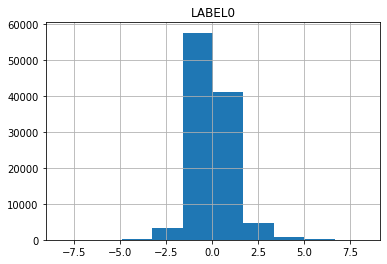

In [7]:
# feature
print(df_train["feature"].head())
# label
print(df_train["label"].head())
# data distribution
df_train["label"].hist()

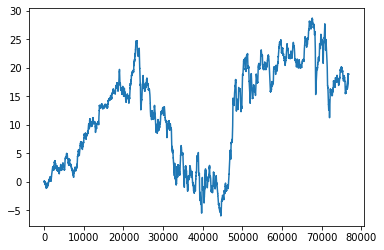

In [8]:
index_i = df_test["label"].cumsum().values
plt.plot(range(len(index_i)),index_i)
plt.show()

Optimization layer
If we do not back prop gradient, then it is just optimization.

In [9]:
def SPOLayers(n):
    wtilde = cp.Variable(n)
    f = cp.Variable(n)

    alpha = cp.Parameter(n)
    S = cp.Parameter((n, n))
    gamma = cp.Parameter(1, nonneg=True)

    expected_return = alpha @ wtilde
    expected_risk = cp.sum_squares(f)

    constraints = [cp.sum(wtilde) == 1, wtilde>=0,cp.norm(wtilde, "inf") <= .5,f == S @ wtilde]

    prob = cp.Problem(
            cp.Maximize(expected_return - gamma * expected_risk),
            constraints)
    return CvxpyLayer(prob, [alpha, S, gamma], [wtilde, f], gp = False)

n = 128
trading_policy = SPOLayers(n)
# w,_ = trading_policy(torch.ones(n), torch.ones((n,n)),torch.ones(1),solver_args={"solve_method": "SCS" , "n_jobs_forward": 1})
# w
# , "gpu":True,"use_indirect":True

/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:188: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  "Your problem has too many parameters for efficient DPP "


Benchmark Model: Linear model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
lr=LinearRegression(fit_intercept=True)
X, y = df_train["feature"].fillna(0).values, np.squeeze(df_train["label"].fillna(0).values)
X_valid, y_valid = df_valid["feature"].fillna(0).values, np.squeeze(df_valid["label"].fillna(0).values)
lr.fit(X,y)
X_valid[np.isinf(X_valid)] = 0
y_predict=lr.predict(X_valid)
print("mean_square_error:%.2f"%mean_squared_error(y_valid,y_predict))
print('Coefficient of determination: %.2f'
      % r2_score(y_valid, y_predict))

print(f"Test IC:{np.corrcoef(y_valid, y_predict)[1,0]*100}%")

mean_square_error:0.01
Coefficient of determination: -9.03
Test IC:1.1651157437517263%


The Test IC in valid set of Linear model is 1.16%

MLP model (batch size = 128, learning rate = 0.0001, epoch = 50)

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(153, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x).requires_grad_()
        return logits


def trainMLP(model, train_loader, valid_dataloader, cost, optimizer, epoch ,seed = 0):
    torch.manual_seed(seed)
    model.train()
    training_log = []
    for e in range(epoch):
        start = time.time()
        running_loss = 0
        correct = 0

        for data, target in train_loader:
            data = data.view(data.shape[0], -1)
            optimizer.zero_grad()
            pred = model(data)
            # 模拟组合优化，梯度不回传，那么loss只能是MSE
            loss = cost(pred, target)
            running_loss += loss
            loss.backward()
            optimizer.step()
            correct += pearsonr(pred.T, target.T).item()

        print('----------------------------')
        print(
            f"Train set: Epoch {e}: Loss: {100*running_loss / len(train_loader)}%, RankIC: {100 * (correct / len(train_loader))}%")
        # validation
        _,_, IC, CumRet = testMLP(model=model, test_loader=valid_dataloader)
        end = time.time()
        print("Time spent:", end - start)
        training_log.append([100*running_loss / len(train_loader),100 * (correct / len(train_loader)), IC, CumRet])
    return training_log

def testMLP(model, test_loader):
    model.eval()
    correct = 0
    error_num = 0
    cummret = 0
    rets = [0.0001]
    with torch.no_grad():
        for data, target in test_loader:
            try:
                data = data.view(data.shape[0], -1)
                output = model(data)
                covs = torch.cov(data)

                w_mlp, _ = trading_policy(torch.squeeze(output), covs.to(device), (torch.ones(1) * 0.5).to(device),
                                          solver_args={"solve_method": "SCS", "n_jobs_forward": 1})
                # print(w_mlp)
                cumret = w_mlp.dot(torch.squeeze(target)).item()
                rets.append(cumret)
                pred = pearsonr(output.T, target.T).item()
                correct += pred
                cummret += cumret
            except:
                error_num += 1
                pass
    IC = 100 * (correct / len(test_loader))
    CumRet = 100 * 252 * sum(rets) / len(rets)
    print(
        f'Test set: IC: {100 * (correct / len(test_loader))}%), CumRet:{100 * 252 * sum(rets) / len(rets)}%, error number:{error_num}')
    return rets, w_mlp, IC, CumRet

In [16]:
trail_num = 3
learning_rate = 0.0001
model_mlp = MLP().to(device)
cost = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model_mlp.parameters(), lr=learning_rate)
training_log = trainMLP(model=model_mlp, train_loader=train_dataloader, valid_dataloader=valid_dataloader, cost=cost, optimizer=optimizer,
         epoch=50)
torch.save(model_mlp.state_dict(), f"./model_save/baseline_MLP_10epoch_train{trail_num}.pkl")

----------------------------
Train set: Epoch 0: Loss: 99.55650329589844%, RankIC: 0.9501362044345387%
Test set: IC: -0.2089442657827103%), CumRet:11.293719538141556%, error number:1
Time spent: 16.402048587799072
----------------------------
Train set: Epoch 1: Loss: 99.2486572265625%, RankIC: 1.0915040975826857%
Test set: IC: -0.028158572151670516%), CumRet:9.936576190587203%, error number:1
Time spent: 16.336189031600952
----------------------------
Train set: Epoch 2: Loss: 99.14546966552734%, RankIC: 1.2066491167153774%
Test set: IC: 0.08325880357637773%), CumRet:8.802707271600212%, error number:1
Time spent: 16.304916858673096
----------------------------
Train set: Epoch 3: Loss: 99.10249328613281%, RankIC: 1.3130151119022813%
Test set: IC: 0.1560473443369061%), CumRet:8.02799577190545%, error number:1
Time spent: 16.141544342041016
----------------------------
Train set: Epoch 4: Loss: 99.07791137695312%, RankIC: 1.4152199606436144%
Test set: IC: 0.2079639390603769%), CumRet:8.

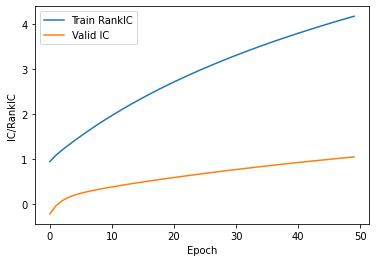

In [18]:
df_plot = pd.DataFrame(training_log, columns=["Train loss","Train RankIC", "Valid IC", "Valid CumRet"])
plt.xlabel("Epoch")
plt.ylabel("IC/RankIC")
plt.plot(range(len(df_plot)),df_plot["Train RankIC"])
plt.plot(range(len(df_plot)),df_plot["Valid IC"])
plt.legend(["Train RankIC","Valid IC"])
plt.show()

OptMLP model (batch size = 128, learning rate = 0.001)

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(153, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        # Pridiction model
        x.requires_grad = False

        logits = self.linear_relu_stack(x).requires_grad_()
        # Decision model

        covs = torch.cov(x)
        covs.requires_grad = False
        # 优化风险厌恶系数
        lamd = torch.ones(1).requires_grad_()

        if logits.isnan().sum()>0:
            logits = torch.where(torch.isnan(logits), torch.full_like(logits, 0), logits)
        if covs.isnan().sum()>0:
            covs = torch.where(torch.isnan(covs), torch.full_like(covs, 100), covs)
        try:
            w_tmp, _ = trading_policy(torch.squeeze(logits), covs.to(device),(lamd * 0.5).to(device),
                                solver_args={"solve_method": "SCS" , "n_jobs_forward": 1})
        except:
            print(logits.isnan().sum())
            print(covs)
            pass

        return w_tmp,logits

In [20]:
def train(model, train_loader, valid_dataloader, cost,optimizer, epoch, seed=0):
    torch.manual_seed(seed)
    model.train()
    training_log = []
    for e in range(epoch):
        start = time.time()
        running_loss=0
        correct = 0
        for data, target in train_loader:
            data = data.view(data.shape[0], -1)
            optimizer.zero_grad()
            pred,ret = model(data)
            loss = -pred.dot(torch.squeeze(target)) + cost(target,ret)
            running_loss+=loss
            loss.backward()
            optimizer.step()
            correct += pearsonr(ret.T, target.T).item() # IC
        print('----------------------------')
        print(f"Train set: Epoch {e}: Loss: {100*running_loss/len(train_loader)}%, RankIC: {100*(correct/len(train_loader))}%")
        # validation
        _,_, IC, CumRet = test(model=model,test_loader=valid_dataloader)
        end = time.time()
        print("Time spent:",end-start)
        training_log.append([100*running_loss/len(train_loader),100*(correct/len(train_loader)),IC,CumRet])
    return training_log

def test(model, test_loader):
    model.eval()
    correct = 0
    cummmret = 0
    rets = []
    error_num = 0
    with torch.no_grad():
        for data, target in test_loader:
            try:
                data = data.view(data.shape[0], -1)
                output, ret = model(data)
                pred = pearsonr(ret.T, target.T).item() # IC
                cumret = output.dot(torch.squeeze(target)).item()
                rets.append(cumret)
                cummmret += cumret
                correct += pred
            except:
                error_num+=1
                pass
    IC = 100*(correct/len(test_loader))
    CumRet = 100*252*sum(rets)/len(rets)
    print(f'Test set: IC: {100*(correct/len(test_loader))}%), CumRet:{100*252*sum(rets)/len(rets)}%,error number:{error_num}')
    return rets,output, IC, CumRet

In [21]:
learning_rate = 0.0001
trail_num = 2
cost = nn.MSELoss().to(device)
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
OptMLP = train(model=model,train_loader=train_dataloader,valid_dataloader=valid_dataloader,cost = cost,optimizer=optimizer,epoch=10)
torch.save(model.state_dict(), f"./model_save/End2EndMLPrisk_10epoch_train{trail_num}.pkl")

----------------------------
Train set: Epoch 0: Loss: 98.42457580566406%, RankIC: 0.7028652029118903%
Test set: IC: 2.199743605417969%), CumRet:11.212150777624231%,error number:0
Time spent: 155.25230383872986
----------------------------
Train set: Epoch 1: Loss: 91.81369018554688%, RankIC: 1.7826141595189717%


/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/diffcp/cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


Test set: IC: 2.4475402873059346%), CumRet:20.806053866930995%,error number:0
Time spent: 170.03593158721924
----------------------------
Train set: Epoch 2: Loss: 87.19697570800781%, RankIC: 2.124428830450616%
Test set: IC: 2.46537100307116%), CumRet:23.31872762126962%,error number:0
Time spent: 157.02126550674438
----------------------------
Train set: Epoch 3: Loss: 83.1046371459961%, RankIC: 2.3915710113072275%
Test set: IC: 2.6410996438796897%), CumRet:20.298790920733914%,error number:0
Time spent: 154.46606850624084
----------------------------
Train set: Epoch 4: Loss: 80.60157012939453%, RankIC: 2.6556693900986024%
Test set: IC: 2.8752704426010625%), CumRet:24.397755542266935%,error number:0
Time spent: 167.14574480056763
----------------------------
Train set: Epoch 5: Loss: 78.36936950683594%, RankIC: 2.8633192860699666%
Test set: IC: 2.9513367252562674%), CumRet:25.541944952417385%,error number:0
Time spent: 158.93020844459534
----------------------------
Train set: Epoch 6:

[[tensor(98.4246, device='cuda:0', grad_fn=<DivBackward0>), 0.7028652029118903, 2.199743605417969, 11.212150777624231], [tensor(91.8137, device='cuda:0', grad_fn=<DivBackward0>), 1.7826141595189717, 2.4475402873059346, 20.806053866930995], [tensor(87.1970, device='cuda:0', grad_fn=<DivBackward0>), 2.124428830450616, 2.46537100307116, 23.31872762126962], [tensor(83.1046, device='cuda:0', grad_fn=<DivBackward0>), 2.3915710113072275, 2.6410996438796897, 20.298790920733914], [tensor(80.6016, device='cuda:0', grad_fn=<DivBackward0>), 2.6556693900986024, 2.8752704426010625, 24.397755542266935], [tensor(78.3694, device='cuda:0', grad_fn=<DivBackward0>), 2.8633192860699666, 2.9513367252562674, 25.541944952417385], [tensor(76.3446, device='cuda:0', grad_fn=<DivBackward0>), 3.137425753124907, 2.8891077510654326, 26.594298431770337], [tensor(74.2990, device='cuda:0', grad_fn=<DivBackward0>), 3.289126290335662, 2.7439960337293012, 26.09673851076813], [tensor(72.2901, device='cuda:0', grad_fn=<DivB

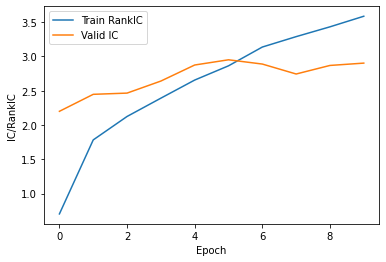

In [22]:
df_plot2 = pd.DataFrame(OptMLP, columns=["Train loss","Train RankIC", "Valid IC", "Valid CumRet"])
print(OptMLP)
plt.xlabel("Epoch")
plt.ylabel("IC/RankIC")
plt.plot(range(len(df_plot2)),df_plot2["Train RankIC"])
plt.plot(range(len(df_plot2)),df_plot2["Valid IC"])
plt.legend(["Train RankIC","Valid IC"])
plt.show()

Prediction of 3 models

In [25]:
def predict_weight(model, test_loader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for data, target in test_loader:

            data = data.view(data.shape[0], -1)
            output, _ = model(data)
            temp_tensor = output.cpu()
            outputs.append(temp_tensor.numpy())
    return np.ravel(outputs)
def predict_weight_linear(model, test_loader):
    return model.predict(test_loader)
def predict_weight_mlp(model, test_loader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for data, target in test_loader:

            data = data.view(data.shape[0], -1)
            output = model(data)
            temp_tensor = output.cpu()
            outputs.append(temp_tensor.numpy())
    return np.ravel(outputs)

In [33]:
X_test = df_test["feature"].fillna(0).values
X_test[np.isinf(X_test)] = 0
rets_linear = predict_weight_linear(model = lr, test_loader = X)
rets_mlp = predict_weight_mlp(model=model_mlp, test_loader=test_dataloader)
rets_opt = predict_weight(model=model, test_loader=test_dataloader)

Backtest preparation

In [41]:
def onenorm(df):
    df = df - df.min()
    return df/ df.sum()
def transfrom_df(df,df_test):
    df = df[:76765] # Droped some data
    dd = df_test.iloc[:len(df),:]['feature']
    dd['score'] = df
    weight = dd['score'].iloc[:len(df)]
    return weight.groupby('datetime').apply(onenorm)

Override generate_target_weight_position() method

In [38]:
from qlib.contrib.strategy import WeightStrategyBase

class Predweight(WeightStrategyBase):
    def __init__(
        self,
        **kwargs,
    ):
        super().__init__(**kwargs)

    def generate_target_weight_position(self, score, current, trade_start_time, trade_end_time):

        target_weight_position = {stock: weight for stock, weight in zip(score.index.values, score.values) if weight > 0}
        # output dict
        return target_weight_position

In [43]:
weight_linear = transfrom_df(rets_linear,df_test)
weight_mlp = transfrom_df(rets_mlp,df_test)
weight_opt = transfrom_df(rets_opt,df_test)

Look at weights

In [44]:
weight_linear

datetime    instrument
2017-01-03  SH600000      0.008884
            SH600010      0.003977
            SH600015      0.013271
            SH600016      0.007417
            SH600018      0.002549
                            ...   
2020-06-01  SZ002594      0.009984
            SZ002736      0.011756
            SZ300015      0.011394
            SZ300059      0.005205
            SZ300498      0.014061
Name: score, Length: 76765, dtype: float32

Apply qlib backtest program

1.Linear backtest

In [46]:
from pprint import pprint
from qlib.utils.time import Freq
import pandas as pd
from qlib.backtest import backtest, executor
from qlib.contrib.evaluate import risk_analysis
from qlib.utils import flatten_dict

STRATEGY_CONFIG = {
    "signal": weight_linear,
}
EXECUTOR_CONFIG = {
    "time_per_step": "day",
    "generate_portfolio_metrics": True,
}
FREQ = "day"
backtest_config = {
    "start_time": "2017-01-01",
    "end_time": "2020-06-01",
    "account": 100000000,
    "benchmark": benchmark,
    "exchange_kwargs": {
        "freq": FREQ,
        "limit_threshold": 0.095,
        "deal_price": "close",
        "open_cost": 0.0005,
        "close_cost": 0.0015,
        "min_cost": 5,
    },
}
strategy_obj = Predweight(**STRATEGY_CONFIG)
executor_obj = executor.SimulatorExecutor(**EXECUTOR_CONFIG)

portfolio_metric_dict, indicator_dict = backtest(executor=executor_obj,strategy=strategy_obj,**backtest_config)
analysis_freq = "{0}{1}".format(*Freq.parse(FREQ))


report_normal_linear, positions_normal = portfolio_metric_dict.get(analysis_freq)

# analysis
analysis = dict()
analysis["excess_return_without_cost"] = risk_analysis(
    report_normal_linear["return"] - report_normal_linear["bench"], freq=analysis_freq
)

analysis_df = pd.concat(analysis)  # type: pd.DataFrame
# log metrics
analysis_dict = flatten_dict(analysis_df["risk"].unstack().T.to_dict())
# print out results
pprint(f"The following are analysis results of benchmark return({analysis_freq}).")
pprint(risk_analysis(report_normal_linear["bench"], freq=analysis_freq))
pprint(analysis["excess_return_without_cost"])

[20997:MainThread](2022-08-22 16:29:21,687) WARNING - qlib.BaseExecutor - [executor.py:127] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x7f4edd3e51d0>
[20997:MainThread](2022-08-22 16:29:21,706) INFO - qlib.backtest caller - [__init__.py:94] - Create new exchange
[20997:MainThread](2022-08-22 16:30:32,985) WARNING - qlib.online operator - [exchange.py:216] - factor.day.bin file not exists or factor contains `nan`. Order using adjusted_price.
[20997:MainThread](2022-08-22 16:30:32,987) WARNING - qlib.online operator - [exchange.py:218] - trade unit 100 is not supported in adjusted_price mode.


backtest loop:   0%|          | 0/829 [00:00<?, ?it/s]

/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/qlib/utils/index_data.py:480: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/qlib/utils/index_data.py:272: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if _indexing.dtype != np.bool:


'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000383
std                0.012031
annualized_return  0.091168
information_ratio  0.491206
max_drawdown      -0.347247
                       risk
mean              -0.000208
std                0.003113
annualized_return -0.049584
information_ratio -1.032555
max_drawdown      -0.172530


2.Opt backtest

In [47]:
STRATEGY_CONFIG = {
    "signal": weight_opt,
}

strategy_obj = Predweight(**STRATEGY_CONFIG)
executor_obj = executor.SimulatorExecutor(**EXECUTOR_CONFIG)

portfolio_metric_dict, indicator_dict = backtest(executor=executor_obj,strategy=strategy_obj,**backtest_config)
analysis_freq = "{0}{1}".format(*Freq.parse(FREQ))


report_normal_opt, positions_normal = portfolio_metric_dict.get(analysis_freq)

# analysis
analysis = dict()
analysis["excess_return_without_cost"] = risk_analysis(
    report_normal_opt["return"] - report_normal_opt["bench"], freq=analysis_freq
)

analysis_df = pd.concat(analysis)  # type: pd.DataFrame
# log metrics
analysis_dict = flatten_dict(analysis_df["risk"].unstack().T.to_dict())
# print out results
pprint(f"The following are analysis results of benchmark return({analysis_freq}).")
pprint(risk_analysis(report_normal_opt["bench"], freq=analysis_freq))
pprint(f"The following are analysis results of the excess return without cost({analysis_freq}).")
pprint(analysis["excess_return_without_cost"])

[20997:MainThread](2022-08-22 16:31:55,646) WARNING - qlib.BaseExecutor - [executor.py:127] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x7f4e803bb550>
[20997:MainThread](2022-08-22 16:31:55,662) INFO - qlib.backtest caller - [__init__.py:94] - Create new exchange
[20997:MainThread](2022-08-22 16:32:54,773) WARNING - qlib.online operator - [exchange.py:216] - factor.day.bin file not exists or factor contains `nan`. Order using adjusted_price.
[20997:MainThread](2022-08-22 16:32:54,775) WARNING - qlib.online operator - [exchange.py:218] - trade unit 100 is not supported in adjusted_price mode.


backtest loop:   0%|          | 0/829 [00:00<?, ?it/s]

/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/qlib/utils/index_data.py:480: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/qlib/utils/index_data.py:272: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if _indexing.dtype != np.bool:


'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000383
std                0.012031
annualized_return  0.091168
information_ratio  0.491206
max_drawdown      -0.347247
'The following are analysis results of the excess return without cost(1day).'
                       risk
mean               0.000021
std                0.006127
annualized_return  0.005014
information_ratio  0.053040
max_drawdown      -0.126793


3.Mlp backtest

In [49]:
STRATEGY_CONFIG = {
    "signal": weight_mlp,
}

strategy_obj = Predweight(**STRATEGY_CONFIG)
executor_obj = executor.SimulatorExecutor(**EXECUTOR_CONFIG)

portfolio_metric_dict, indicator_dict = backtest(executor=executor_obj,strategy=strategy_obj,**backtest_config)
analysis_freq = "{0}{1}".format(*Freq.parse(FREQ))


report_normal_mlp, positions_normal = portfolio_metric_dict.get(analysis_freq)

# analysis
analysis = dict()
analysis["excess_return_without_cost"] = risk_analysis(
    report_normal_mlp["return"] - report_normal_mlp["bench"], freq=analysis_freq
)

analysis_df = pd.concat(analysis)  # type: pd.DataFrame
# log metrics
analysis_dict = flatten_dict(analysis_df["risk"].unstack().T.to_dict())
# print out results
pprint(f"The following are analysis results of benchmark return({analysis_freq}).")
pprint(risk_analysis(report_normal_mlp["bench"], freq=analysis_freq))
pprint(f"The following are analysis results of the excess return without cost({analysis_freq}).")
pprint(analysis["excess_return_without_cost"])

[20997:MainThread](2022-08-22 16:37:15,736) WARNING - qlib.BaseExecutor - [executor.py:127] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x7f4e62a67c10>
[20997:MainThread](2022-08-22 16:37:15,767) INFO - qlib.backtest caller - [__init__.py:94] - Create new exchange
[20997:MainThread](2022-08-22 16:38:11,763) WARNING - qlib.online operator - [exchange.py:216] - factor.day.bin file not exists or factor contains `nan`. Order using adjusted_price.
[20997:MainThread](2022-08-22 16:38:11,766) WARNING - qlib.online operator - [exchange.py:218] - trade unit 100 is not supported in adjusted_price mode.


backtest loop:   0%|          | 0/829 [00:00<?, ?it/s]

/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/qlib/utils/index_data.py:480: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/qlib/utils/index_data.py:272: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if _indexing.dtype != np.bool:


'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000383
std                0.012031
annualized_return  0.091168
information_ratio  0.491206
max_drawdown      -0.347247
'The following are analysis results of the excess return without cost(1day).'
                       risk
mean              -0.000078
std                0.003158
annualized_return -0.018501
information_ratio -0.379776
max_drawdown      -0.100170


Compare three models

<AxesSubplot:xlabel='datetime'>

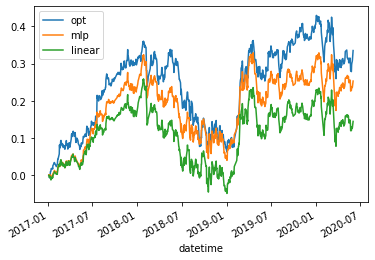

In [62]:
df_plot3 = pd.DataFrame([report_normal_opt["return"], report_normal_mlp["return"], report_normal_linear["return"]])
df_plot3 = df_plot3.T
df_plot3.columns = ["opt","mlp","linear"]
df_plot3.cumsum(axis=0).plot()

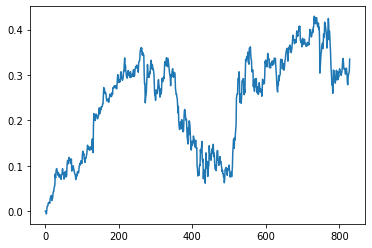

In [55]:
plt.plot(range(len(report_normal_opt["return"])),report_normal_opt["return"].cumsum())

plt.show()

AttributeError: 'Series' object has no attribute 'to_series'